In [1]:
import rerun as rr
from jax.scipy.spatial.transform import Rotation as R
import numpy as np
from scipy.spatial.transform import Rotation

rr.init("test")
rr.connect("127.0.0.1:8813")

In [2]:
def rr_log_posquat(posquat, channel="pose", scale=0.1):
    position = posquat[:3]
    origins = np.tile(position[None, ...], (3, 1))
    colors = np.eye(3)
    rotation_matrix = R.from_quat(posquat[3:]).as_matrix()
    rr.log(
        channel,
        rr.Arrows3D(origins=origins, vectors=rotation_matrix.T * scale, colors=colors),
    )
rr_log_posquat(np.array([0,0,0, 0,0,0,1]), 'pose0', 1)


In [3]:
x = 1
y = 0
z = 1
w = 1

rot = Rotation.from_quat([x, y, z, w])
rot_quat = rot.as_quat()
rr_log_posquat(np.concatenate([np.array([0,0,0]), rot_quat]), 'pose1')


In [4]:
rot.as_euler('xyz', degrees=True)

array([ 63.43494882, -41.8103149 ,  63.43494882])

In [5]:
a, b, c = rot.as_euler('xyz', degrees=True)
a, b, c

(63.43494882292201, -41.810314895778596, 63.43494882292201)

In [6]:
rot_new = Rotation.from_euler('xyz', [a, b+60, c], degrees=True)
rot_quat_new = rot_new.as_quat()
rr_log_posquat(np.concatenate([np.array([0,0,0]), rot_quat_new]), 'pose2')


In [7]:
rot_new.as_euler('xyz', degrees=True)


array([63.43494882, 18.1896851 , 63.43494882])

In [8]:
x = 1
y = 0
z = 1
w = 1
rot = Rotation.from_quat([x, y, z, w])
rot.as_euler('xyz', degrees=True)


array([ 63.43494882, -41.8103149 ,  63.43494882])

In [10]:
rot = Rotation.from_quat([x, y+2, z, w])
rot.as_euler('xyz', degrees=True)

array([116.56505118,  16.6015496 , 116.56505118])

In [7]:
x = 90
y = 45
z = 30

rot = Rotation.from_euler('xyz', [x, y, z], degrees=True)
rot_quat = rot.as_quat()
rr_log_posquat(np.concatenate([np.array([0,0,0]), rot_quat]), 'pose1')

rot_new = Rotation.from_euler('xyz', [x, y+60, z], degrees=True)
rot_quat_new = rot_new.as_quat()
rr_log_posquat(np.concatenate([np.array([0,0,0]), rot_quat_new]), 'pose2')


In [2]:


def normalize_quaternion(q):
    """Normalize a quaternion to ensure it represents a valid rotation."""
    norm = np.sqrt(np.sum(np.square(q)))
    return q / norm

def quaternion_multiply(q1, q2):
    """
    Multiply two quaternions q1 and q2 in [x, y, z, w] order.
    Quaternion q = [x, y, z, w].
    """
    x1, y1, z1, w1 = q1
    x2, y2, z2, w2 = q2

    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2

    return np.array([x, y, z, w])

def modify_y_rotation(quaternion, theta_y_new):
    """
    Modify the rotation around the Y-axis of a given quaternion in [x, y, z, w] order.
    
    Args:
        quaternion: List or array representing the quaternion [x, y, z, w].
        theta_y_new: New rotation angle around the Y-axis (in radians).

    Returns:
        A new quaternion with the updated Y-axis rotation.
    """
    # Create a quaternion for the new Y-axis rotation in [x, y, z, w] order
    w_new = np.cos(theta_y_new / 2)
    y_new = np.sin(theta_y_new / 2)
    q_y_new = np.array([0, y_new, 0, w_new])  # Only Y-axis rotation

    # Multiply the new Y-axis rotation quaternion with the original quaternion
    q_modified = quaternion_multiply(q_y_new, quaternion)

    # Normalize the resulting quaternion
    return normalize_quaternion(q_modified)


In [ ]:

# # Example usage
# original_quaternion = normalize_quaternion(np.array([0.1, 0.5, 0.2, 0.8]))
# rr_log_posquat(np.concatenate([np.array([0,0,0]), original_quaternion]), 'pose1')

# theta_y_new = np.pi / 2  # 90 degrees rotation around Y-axis
# new_quaternion = modify_y_rotation(original_quaternion, theta_y_new)
# rr_log_posquat(np.concatenate([np.array([0,0,0]), new_quaternion]), 'pose2')
# print("Modified Quaternion (in [x, y, z, w] order):", new_quaternion)


In [4]:
import math

def quaternion_to_euler(x, y, z, w):
    """
    Convert a quaternion (x, y, z, w) into Euler angles (roll, pitch, yaw).
    Assumes the quaternion uses the 'w-last' ordering: (x, y, z, w).
    The returned angles are in radians.

    Convention used:
      - roll  is rotation around X
      - pitch is rotation around Y
      - yaw   is rotation around Z
    (i.e., intrinsic Tait-Bryan angles in the order X -> Y -> Z)
    """

    # roll (x-axis rotation)
    sinr_cosp = 2.0 * (w * x + y * z)
    cosr_cosp = 1.0 - 2.0 * (x * x + y * y)
    roll = math.atan2(sinr_cosp, cosr_cosp)

    # pitch (y-axis rotation)
    sinp = 2.0 * (w * y - z * x)
    if abs(sinp) >= 1:
        # use 90 degrees if out of range
        pitch = math.copysign(math.pi / 2, sinp)
    else:
        pitch = math.asin(sinp)

    # yaw (z-axis rotation)
    siny_cosp = 2.0 * (w * z + x * y)
    cosy_cosp = 1.0 - 2.0 * (y * y + z * z)
    yaw = math.atan2(siny_cosp, cosy_cosp)

    return roll, pitch, yaw

def euler_to_quaternion(roll, pitch, yaw):
    """
    Convert Euler angles (roll, pitch, yaw) into a quaternion (x, y, z, w).
    Assumes the angles are in radians, and the quaternion is returned in
    w-last ordering: (x, y, z, w).

    Convention used must match quaternion_to_euler for consistency.
    """

    cy = math.cos(yaw * 0.5)
    sy = math.sin(yaw * 0.5)
    cp = math.cos(pitch * 0.5)
    sp = math.sin(pitch * 0.5)
    cr = math.cos(roll * 0.5)
    sr = math.sin(roll * 0.5)

    w = cr * cp * cy + sr * sp * sy
    x = sr * cp * cy - cr * sp * sy
    y = cr * sp * cy + sr * cp * sy
    z = cr * cp * sy - sr * sp * cy

    return x, y, z, w

def keep_only_y_rotation(x, y, z, w):
    """
    Given a quaternion (x, y, z, w), return a new quaternion that only
    preserves the rotation about the Y-axis.
    """

    # 1. Convert to Euler angles
    roll, pitch, yaw = quaternion_to_euler(x, y, z, w)

    # 2. Zero out roll (X) and pitch (Y) -- keep only yaw (Z).
    roll = 0.0
    pitch = 0.0

    # 3. Convert back to quaternion
    x_new, y_new, z_new, w_new = euler_to_quaternion(roll, pitch, yaw)

    return x_new, y_new, z_new, w_new

# Example usage:

# Original quaternion (example): 45° around X, 30° around Y, 60° around Z.
# Let's say we have one such quaternion:
# For demonstration, let's build it from euler angles first:
original_q = euler_to_quaternion(
    math.radians(45),  # roll (X)   = 45°
    math.radians(30),  # pitch (Y) = 30°
    math.radians(60)   # yaw (Z)   = 60°
)
rr_log_posquat(np.concatenate([np.array([0,0,0]), normalize_quaternion(original_q)]), 'pose1')
print("Original quaternion (x, y, z, w) =", original_q)

# Now keep only the rotation about Y-axis:
y_only_q = keep_only_y_rotation(*original_q)
print("Y-axis-only quaternion (x, y, z, w) =", y_only_q)

# Let's check what the resulting Euler angles are:
roll_y, pitch_y, yaw_y = quaternion_to_euler(*y_only_q)
print(f"Resulting Euler angles (roll, pitch, yaw) in degrees = "
        f"({math.degrees(roll_y):.2f}, {math.degrees(pitch_y):.2f}, {math.degrees(yaw_y):.2f})")

new_q = euler_to_quaternion(
    math.radians(45),  # roll (X)   = 45°
    math.radians(30),  # pitch (Y) = 30°
    yaw_y+1   # yaw (Z)   = 60°
)
rr_log_posquat(np.concatenate([np.array([0,0,0]), normalize_quaternion(new_q)]), 'pose2')


Original quaternion (x, y, z, w) = (0.20056212114657512, 0.3919038373291199, 0.3604234056503559, 0.8223631719059994)
Y-axis-only quaternion (x, y, z, w) = (0.0, 0.0, 0.49999999999999994, 0.8660254037844387)
Resulting Euler angles (roll, pitch, yaw) in degrees = (0.00, 0.00, 60.00)


In [13]:
rr_log_posquat(np.concatenate([np.array([0,0,0]), normalize(np.array([1,2,3,4]))]), 'pose1')
rr_log_posquat(np.concatenate([np.array([0,0,0]), normalize(np.array([1,6,3,4]))]), 'pose2')
# rr_log_posquat(np.array([0,0,1, 0,0,0,1]), 'pose2')

# rr_log_pose(Pose.from_quat(jnp.array([0,0.5,0,1])))
# rr_log_pose(Pose.from_quat(jnp.array([0,0.5,0,1])).normalize())

In [3]:
import h5py
import os
import numpy as np

hdf5_file_path = '/home/haoliangwang/data/physion_hdf5/drop_all_movies/pilot_it2_drop_simple_box_0018.hdf5'
with h5py.File(hdf5_file_path, "r") as f:
    # extract depth info
    print(len(f["frames"].keys()))

42


In [5]:
lengths = {}
path = '/home/haoliangwang/data/physion_hdf5/'
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.hdf5'):
            print(file)
            hdf5_file_path = os.path.join(root, file)
            with h5py.File(hdf5_file_path, "r") as f:
                lengths[file] = len(f["frames"].keys())

pilot-containment-cone-plate_0031.hdf5
pilot-containment-bowl-familiarization_0018.hdf5
pilot-containment-bowl_0026.hdf5
pilot-containment-multi-bowl_0048.hdf5
pilot-containment-cylinder-bowl_0021.hdf5
pilot-containment-vase_torus_0033.hdf5
pilot-containment-multi-bowl_0029.hdf5
pilot-containment-bowl-familiarization_0033.hdf5
pilot-containment-vase_torus_0009.hdf5
pilot-containment-multi-bowl_0025.hdf5
pilot-containment-vase_torus_0043.hdf5
pilot-containment-vase_torus_0031.hdf5
pilot-containment-bowl-familiarization_0026.hdf5
pilot-containment-vase_torus_0032.hdf5
pilot-containment-torus_0022.hdf5
pilot-containment-bowl-familiarization_0024.hdf5
pilot-containment-bowl-familiarization_0035.hdf5
pilot-containment-bowl_0000.hdf5
pilot-containment-cylinder-bowl_0010.hdf5
pilot-containment-vase_0000.hdf5
pilot-containment-cylinder-bowl_0028.hdf5
pilot-containment-cylinder-bowl_0026.hdf5
pilot-containment-multi-bowl_0042.hdf5
pilot-containment-torus_0017.hdf5
pilot-containment-cylinder-bow

In [8]:
min_value = min(lengths.values())
min_keys = [key for key, val in lengths.items() if val == min_value]
min_keys

['pilot_it2_drop_simple_box_0018.hdf5',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0001.hdf5',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0003.hdf5']

In [13]:
initial_positions = []
path = '/home/haoliangwang/data/physion_hdf5/'
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.hdf5'):
            print(file)
            hdf5_file_path = os.path.join(root, file)
            with h5py.File(hdf5_file_path, "r") as f:
                initial_position = np.array(f['static']['initial_position'])
                initial_positions.append(initial_position)
initial_positions = np.concatenate(initial_positions)


pilot-containment-cone-plate_0031.hdf5
pilot-containment-bowl-familiarization_0018.hdf5
pilot-containment-bowl_0026.hdf5
pilot-containment-multi-bowl_0048.hdf5
pilot-containment-cylinder-bowl_0021.hdf5
pilot-containment-vase_torus_0033.hdf5
pilot-containment-multi-bowl_0029.hdf5
pilot-containment-bowl-familiarization_0033.hdf5
pilot-containment-vase_torus_0009.hdf5
pilot-containment-multi-bowl_0025.hdf5
pilot-containment-vase_torus_0043.hdf5
pilot-containment-vase_torus_0031.hdf5
pilot-containment-bowl-familiarization_0026.hdf5
pilot-containment-vase_torus_0032.hdf5
pilot-containment-torus_0022.hdf5
pilot-containment-bowl-familiarization_0024.hdf5
pilot-containment-bowl-familiarization_0035.hdf5
pilot-containment-bowl_0000.hdf5
pilot-containment-cylinder-bowl_0010.hdf5
pilot-containment-vase_0000.hdf5
pilot-containment-cylinder-bowl_0028.hdf5
pilot-containment-cylinder-bowl_0026.hdf5
pilot-containment-multi-bowl_0042.hdf5
pilot-containment-torus_0017.hdf5
pilot-containment-cylinder-bow

In [21]:
initial_positions[:,1]

array([0.  , 0.  , 0.  , ..., 1.31, 1.81, 2.21], dtype=float32)

In [22]:
np.min(initial_positions[:,1])

0.0

In [18]:
import os
import uuid
from os import listdir
from os.path import isfile, join

In [19]:
scenario_path = '/home/haoliangwang/data/physion_hdf5/dominoes_all_movies'
onlyhdf5 = [
        f
        for f in listdir(scenario_path)
        if isfile(join(scenario_path, f)) and join(scenario_path, f).endswith(".hdf5")
    ]
onlyhdf5

['pilot_dominoes_2mid_J025R30_tdwroom_0025.hdf5',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0005.hdf5',
 'pilot_dominoes_4midRM1_boxroom_0026.hdf5',
 'pilot_dominoes_4midRM1_tdwroom_2_0021.hdf5',
 'pilot_dominoes_4midRM1_tdwroom_2_0018.hdf5',
 'pilot_dominoes_4midRM1_tdwroom_2_0024.hdf5',
 'pilot_dominoes_4midRM1_boxroom_0000.hdf5',
 'pilot_dominoes_default_boxroom_0020.hdf5',
 'pilot_dominoes_4mid_boxroom_0013.hdf5',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0002.hdf5',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0022.hdf5',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0004.hdf5',
 'pilot_dominoes_4midRM1_boxroom_2_0016.hdf5',
 'pilot_dominoes_1mid_J025R45_boxroom_0024.hdf5',
 'pilot_dominoes_4mid_tdwroom_0004.hdf5',
 'pilot_dominoes_1mid_J025R45_boxroom_0022.hdf5',
 'pilot_dominoes_4mid_boxroom_2_0008.hdf5',
 'pilot_dominoes_4mid_boxroom_2_0020.hdf5',
 'pilot_dominoes_4midRM1_boxroom_0019.hdf5',
 'pilot_dominoes_1mid_J025R45_boxroom_0011.hdf5'

In [23]:
import io
from PIL import Image
import numpy as np
import h5py
import matplotlib.pyplot as plt
from functools import reduce
import os

In [24]:
_M_RGB2YUV = [[0.299, 0.587, 0.114], [-0.14713, -0.28886, 0.436], [0.615, -0.51499, -0.10001]]
_M_YUV2RGB = [[1.0, 0.0, 1.13983], [1.0, -0.39465, -0.58060], [1.0, 2.03211, 0.0]]

def get_mask_area(seg_img, colors):
    arrs = []
    for color in colors:
        arr = seg_img == color
        arr = arr.min(-1).astype("float32")
        arr = arr.reshape((arr.shape[-1], arr.shape[-1])).astype(bool)
        arrs.append(arr)
    return reduce(np.logical_or, arrs)

def convert_PIL_to_numpy(image, format):
    """
    Convert PIL image to numpy array of target format.

    Args:
        image (PIL.Image): a PIL image
        format (str): the format of output image

    Returns:
        (np.ndarray): also see `read_image`
    """
    if format is not None:
        # PIL only supports RGB, so convert to RGB and flip channels over below
        conversion_format = format
        if format in ["BGR", "YUV-BT.601"]:
            conversion_format = "RGB"
        image = image.convert(conversion_format)
    image = np.asarray(image)
    # PIL squeezes out the channel dimension for "L", so make it HWC
    if format == "L":
        image = np.expand_dims(image, -1)

    # handle formats not supported by PIL
    elif format == "BGR":
        # flip channels if needed
        image = image[:, :, ::-1]
    elif format == "YUV-BT.601":
        image = image / 255.0
        image = np.dot(image, np.array(_M_RGB2YUV).T)

    return image

def blackout_image(depth_map, area):
    # zero_depth_map = np.ones(depth_map.shape)
    zero_depth_map = np.zeros(depth_map.shape)
    zero_depth_map[area] = depth_map[area]
    return zero_depth_map

def load_trial(hdf5_file_path, START_T, FINAL_T):
    flow_arr = []
    depth_arr = []
    image_arr = []
    seg_arr = []
    velocity_arr = []
    angular_velocity_arr = []
    with h5py.File(hdf5_file_path, "r") as f:
        distractors = (
            np.array(f["static"]["distractors"])
            if np.array(f["static"]["distractors"]).size != 0
            else []
        )
        occluders = (
            np.array(f["static"]["occluders"])
            if np.array(f["static"]["occluders"]).size != 0
            else []
        )
        distractors_occluders = np.concatenate([distractors, occluders])

        # extract depth info
        for frame in f["frames"].keys():
            if int(frame) >= FINAL_T or int(frame) < START_T:
                continue
            flow = np.array(Image.open(io.BytesIO(f["frames"][frame]["images"]["_flow_cam0"][:])))
            flow_arr.append(flow)
            depth = np.array(f["frames"][frame]["images"]["_depth_cam0"])
            depth_arr.append(depth)
            image = np.array(
                Image.open(io.BytesIO(f["frames"][frame]["images"]["_img_cam0"][:]))
            )
            image_arr.append(image)
            im_seg = np.array(
                Image.open(io.BytesIO(f["frames"][frame]["images"]["_id_cam0"][:]))
            )
            seg_arr.append(im_seg)

            velocities = np.array(f["frames"][frame]["objects"]["velocities"][:])
            angular_velocities = np.array(f["frames"][frame]["objects"]["angular_velocities"][:])
            if len(distractors_occluders):
                velocities = velocities[
                    : -len(distractors_occluders)
                ]
                angular_velocities = angular_velocities[
                    : -len(distractors_occluders)
                ]
            velocity_arr.append(velocities)
            angular_velocity_arr.append(angular_velocities)

        # flow_arr = np.asarray(flow_arr)
        depth_arr = np.asarray(depth_arr)
        image_arr = np.asarray(image_arr) / 255
        seg_arr = np.asarray(seg_arr)
        
        # extract object info
        object_ids = np.array(f["static"]["object_ids"])
        object_segmentation_colors = np.array(
            f["static"]["object_segmentation_colors"]
        )
        assert len(object_ids) == len(object_segmentation_colors)
        
        if len(distractors_occluders):
            object_ids = object_ids[: -len(distractors_occluders)]
            object_segmentation_colors = object_segmentation_colors[
                : -len(distractors_occluders)
            ]
    rgbds = np.concatenate(
        [image_arr, np.reshape(depth_arr, depth_arr.shape + (1,))], axis=-1
    )
    return (
        rgbds,
        flow_arr,
        seg_arr,
        sorted(object_ids),
        object_segmentation_colors,
        velocity_arr,
        angular_velocity_arr,
    )

def calculate_start_final(path):
    start = 0
    final = 45
    if "pilot_it2_collision" in path:
        final = 15
    if "dominoes" in path:
        start = 14
    return (start, final)

def cal_diff(rgbds, seg_arr, object_segmentation_colors, object_ids, velocity_arr, angular_velocity_arr):
    diffs = []
    vels = []
    angs = []
    for t in range(1, len(rgbds)):
        t1 = t-1
        seg1 = seg_arr[t1]
        seg2 = seg_arr[t]
        diff = rgbds[t][...,3] - rgbds[t1][...,3]
        for i, (o_id, color) in enumerate(zip(object_ids, object_segmentation_colors)):
            mask1 = get_mask_area(seg1, [color])
            mask2 = get_mask_area(seg2, [color])
            mask = np.logical_and(mask1, mask2)
            area = diff[mask]
            diff_area = np.sum(area)
            diffs.append(np.abs(diff_area))
            vels.append(np.linalg.norm(velocity_arr[t][i]))
            angs.append(np.linalg.norm(angular_velocity_arr[t][i]))
    return diffs, vels, angs

In [15]:
diffs = []
vels = []
angs = []
path = '/home/haoliangwang/data/physion_hdf5/collide_all_movies'
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.hdf5'):
            print(file)
            hdf5_file_path = os.path.join(root, file)
            start, final = calculate_start_final(hdf5_file_path)
            rgbds, flow_arr, seg_arr, object_ids, object_segmentation_colors, velocity_arr, angular_velocity_arr = load_trial(hdf5_file_path, start, final)
            diff, vel, ang = cal_diff(rgbds, seg_arr, object_segmentation_colors, object_ids, velocity_arr, angular_velocity_arr)
            diffs.extend(diff)
            vels.extend(vel)
            angs.extend(ang)

pilot_it2_collision_simple_box_1_dis_1_occ_0034.hdf5
pilot_it2_collision_non-sphere_box_0003.hdf5
pilot_it2_collision_yeet_tdw_1_dis_1_occ_0038.hdf5
pilot_it2_collision_tiny_ball_box_0023.hdf5
pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0025.hdf5
pilot_it2_collision_simple_box_1_dis_1_occ_0014.hdf5
pilot_it2_collision_yeet_tdw_1_dis_1_occ_0025.hdf5
pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0039.hdf5
pilot_it2_collision_tiny_ball_box_0037.hdf5
pilot_it2_collision_simple_box_1_dis_1_occ_0018.hdf5
pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0028.hdf5
pilot_it2_collision_tiny_ball_box_0013.hdf5
pilot_it2_collision_non-sphere_box_0012.hdf5
pilot_it2_collision_yeet_tdw_1_dis_1_occ_0021.hdf5
pilot_it2_collision_assorted_targets_box_0017.hdf5
pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0030.hdf5
pilot_it2_collision_yeet_tdw_1_dis_1_occ_0039.hdf5
pilot_it2_collision_yeet_tdw_1_dis_1_occ_0007.hdf5
pilot_it2_collision_simple_box_0017.hdf5
pilot_it2_collision_non-sphere_box_0021.hdf5

KeyboardInterrupt: 

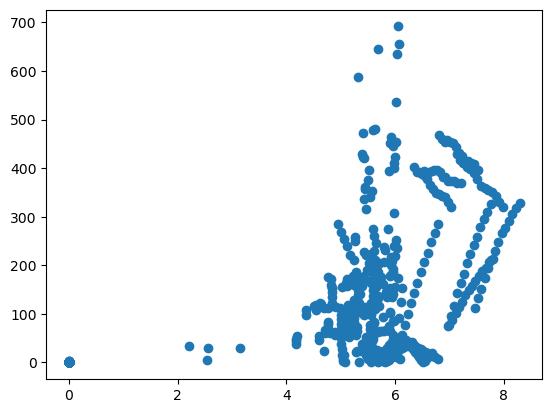

In [16]:
plt.scatter(vels, diffs)

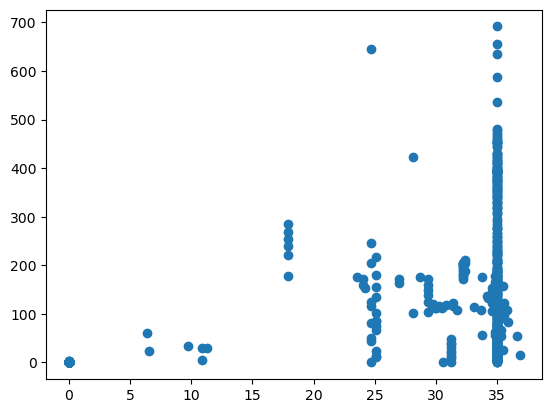

In [17]:
plt.scatter(angs, diffs)

In [32]:
zero_vel_indices = [i for i, x in enumerate(vels) if x == 0]
corr_diffs = [diffs[idx] for idx in zero_vel_indices]
if any(elt != 0 for elt in corr_diffs):
    print("Non zero detected")
else:
    print("All elements are zero")

All elements are zero


In [39]:
zero_diff_indices = [i for i, x in enumerate(diffs) if x == 0]
corr_vels = [vels[idx] for idx in zero_diff_indices]
if any(np.abs(elt) > 1e-05 for elt in corr_vels):
    print("Non zero detected")
else:
    print("All elements are zero")

All elements are zero


In [40]:
diffs

[0.0,
 0.0,
 105.30630278587341,
 0.0,
 0.003725767135620117,
 107.1027946472168,
 0.0,
 0.0,
 114.41938614845276,
 0.0,
 0.0,
 108.94799876213074,
 0.0,
 0.0,
 115.44370746612549,
 0.0,
 0.002335071563720703,
 121.83983445167542,
 0.0,
 0.002335071563720703,
 118.01499509811401,
 0.0,
 0.002335071563720703,
 111.68697166442871,
 0.0,
 0.002335071563720703,
 114.74663758277893,
 0.0,
 0.002335071563720703,
 115.27725577354431,
 0.0,
 0.0,
 112.93396091461182,
 0.0,
 0.002335071563720703,
 111.73572111129761,
 0.0,
 0.0,
 120.04216313362122,
 0.0,
 0.0,
 116.22936654090881,
 0.0,
 0.005461454391479492,
 56.185425996780396,
 0.0,
 0.0016720294952392578,
 21.013108253479004,
 0.0,
 0.0,
 23.31079125404358,
 0.0,
 0.004704952239990234,
 110.5832793712616,
 0.0,
 0.004704952239990234,
 588.0346493721008,
 0.0,
 0.0,
 115.75651502609253,
 0.0,
 0.004704952239990234,
 645.8251252174377,
 0.0,
 0.004704952239990234,
 246.90920162200928,
 0.0,
 0.0,
 124.09623122215271,
 0.0,
 0.004704952239990

In [39]:
hdf5_file_path = "/home/haoliangwang/data/physion_hdf5/collide_all_movies/pilot_it2_collision_yeet_tdw_1_dis_1_occ_0039.hdf5"
rgbds, flow_arr, seg_arr, object_ids, object_segmentation_colors, velocity_arr, angular_velocity_arr = load_trial(hdf5_file_path, 0, 15)

In [12]:
len(flow_arr)

45

In [13]:
flow_arr[0].shape

(1024, 1024, 3)

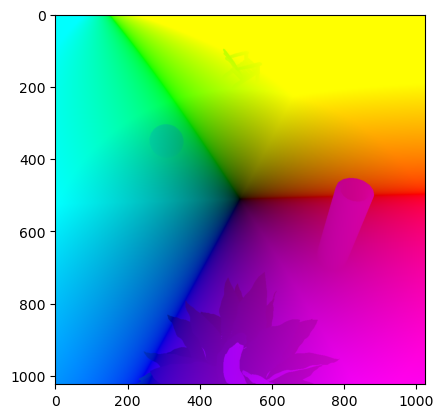

In [14]:
plt.imshow(flow_arr[0])

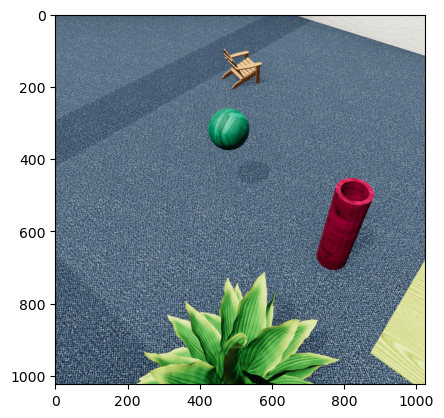

In [43]:
plt.imshow(rgbds[14][...,:3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7098039215686275..0.7058823529411765].


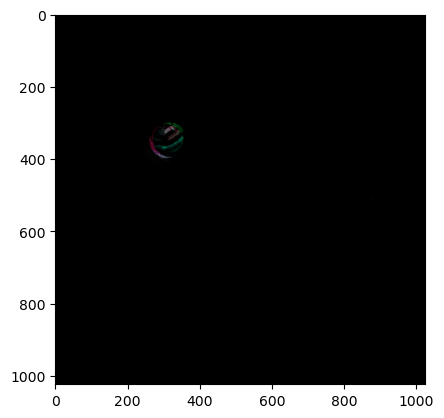

In [41]:
t1 = 0
t2 = 1

plt.imshow(rgbds[t2][...,:3] - rgbds[t1][...,:3])
# plt.imshow(rgbds[t2] - rgbds[t1])
# plt.imshow(rgbds[t2][...,3] - rgbds[t1][...,3])

In [14]:
for t in range(1, 45):
    print(t)
    t1 = t-1
    seg1 = seg_arr[t1]
    seg2 = seg_arr[t]
    # diff = rgbds[t] - rgbds[t1]
    diff = rgbds[t][...,3] - rgbds[t1][...,3]
    # diff = rgbds[t2][...,:3] - rgbds[t1][...,:3]
    for i, (o_id, color) in enumerate(zip(object_ids, object_segmentation_colors)):
        mask1 = get_mask_area(seg1, [color])
        area1 = diff[mask1]
        diff_area1 = np.sum(area1)
        
        mask2 = get_mask_area(seg2, [color])
        area2 = diff[mask2]
        diff_area2 = np.sum(area2)
        # print(f"Object {o_id}: {np.abs(diff_area1)}, {np.abs(diff_area2)}")
        print(f"Object {o_id}: {np.abs(diff_area1)+np.abs(diff_area2)}")
        # if np.abs(diff_area2) > 100.0:
        #     print(f"Object {o_id}: {diff_area2 + diff_area1}")

        # fig = plt.figure(figsize=[10, 5])
        # ax = fig.add_subplot(121)
        # ax.imshow(area1)
        # ax = fig.add_subplot(122)
        # ax.imshow(area2)
        # fig.suptitle(f'{diff_area2 + diff_area1}')



1
Object 1: 0.0
Object 2: 0.006872653961181641
Object 3: 830.3834629058838
2
Object 1: 0.0
Object 2: 0.0007624626159667969
Object 3: 775.3617413043976
3
Object 1: 0.0
Object 2: 0.0011792182922363281
Object 3: 797.7116115093231
4
Object 1: 0.0
Object 2: 0.0009050369262695312
Object 3: 827.5373408794403
5
Object 1: 0.0
Object 2: 0.0009050369262695312
Object 3: 841.9913663864136
6
Object 1: 0.0
Object 2: 0.0
Object 3: 861.685338973999
7
Object 1: 0.0
Object 2: 0.0
Object 3: 886.3532838821411
8
Object 1: 0.0
Object 2: 0.0
Object 3: 888.5845777988434
9
Object 1: 0.0
Object 2: 0.0002741813659667969
Object 3: 896.7177956104279
10
Object 1: 0.0
Object 2: 0.0
Object 3: 900.9870340824127
11
Object 1: 0.0
Object 2: 0.0002741813659667969
Object 3: 887.9562435150146
12
Object 1: 0.0
Object 2: 0.0
Object 3: 879.8965404033661
13
Object 1: 0.0
Object 2: 0.0006546974182128906
Object 3: 834.8782210350037
14
Object 1: 0.0
Object 2: 0.0006546974182128906
Object 3: 847.7418985366821


In [42]:
for t in range(1, 15):
    print(t)
    t1 = t-1
    seg1 = seg_arr[t1]
    seg2 = seg_arr[t]
    # diff = rgbds[t] - rgbds[t1]
    diff = rgbds[t][...,3] - rgbds[t1][...,3]
    # diff = rgbds[t2][...,:3] - rgbds[t1][...,:3]
    for i, (o_id, color) in enumerate(zip(object_ids, object_segmentation_colors)):
        mask1 = get_mask_area(seg1, [color])
        mask2 = get_mask_area(seg2, [color])
        mask = np.logical_and(mask1, mask2)
        area = np.abs(diff[mask])
        diff_area = np.sum(area)
        
        print(f"Object {o_id}: {diff_area} {diff_area/diff[mask].shape[0]} {diff_area/diff[mask1].shape[0]}")
        # if np.abs(diff_area2) > 100.0:
        #     print(f"Object {o_id}: {diff_area2 + diff_area1}")

        # fig = plt.figure(figsize=[10, 5])
        # ax = fig.add_subplot(121)
        # ax.imshow(area1)
        # ax = fig.add_subplot(122)
        # ax.imshow(area2)
        # fig.suptitle(f'{diff_area2 + diff_area1}')



1
Object 1: 0.0 0.0 0.0
Object 2: 2.412108898162842 0.00010021225168935779 0.00010019143917602666
Object 3: 372.76429438591003 0.061644500477246573 0.05365058928985464
2
Object 1: 0.0 0.0 0.0
Object 2: 0.4424285888671875 1.837328026857091e-05 1.8372517290278124e-05
Object 3: 374.13959074020386 0.06024792121420352 0.052415185029448565
3
Object 1: 0.0 0.0 0.0
Object 2: 0.3355855941772461 1.3936857601114918e-05 1.3935700102871397e-05
Object 3: 377.7083296775818 0.05906306953519653 0.05132604017904359
4
Object 1: 0.0 0.0 0.0
Object 2: 0.265122652053833 1.1010076912534594e-05 1.1010076912534594e-05
Object 3: 378.2526390552521 0.057713249779562416 0.04991457364149539
5
Object 1: 0.0 0.0 0.0
Object 2: 0.1359996795654297 5.647827224477977e-06 5.647827224477977e-06
Object 3: 380.37196016311646 0.05645176019042987 0.04880317682359719
6
Object 1: 0.0 0.0 0.0
Object 2: 0.10187268257141113 4.230593130041991e-06 4.230593130041991e-06
Object 3: 387.12196707725525 0.05600722903316772 0.048239497455109

In [32]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

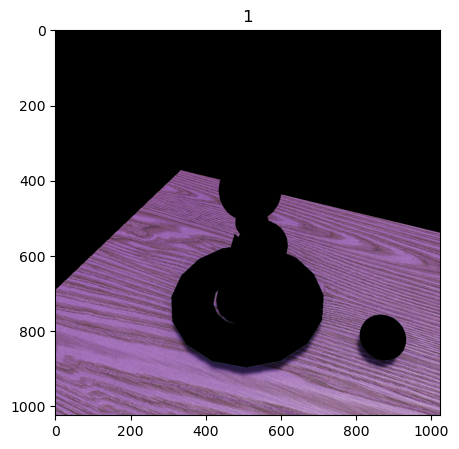

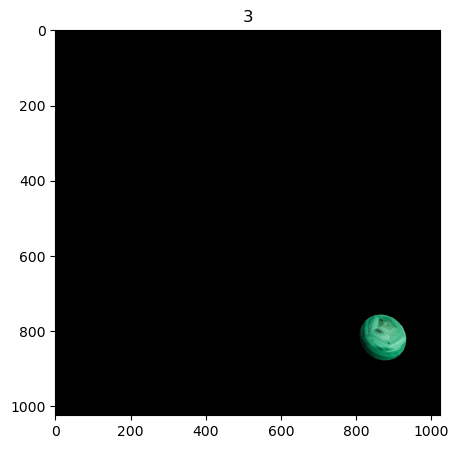

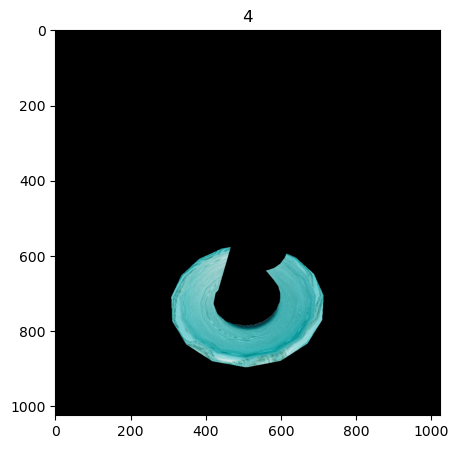

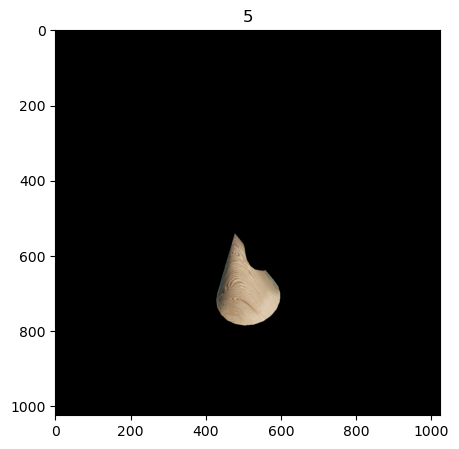

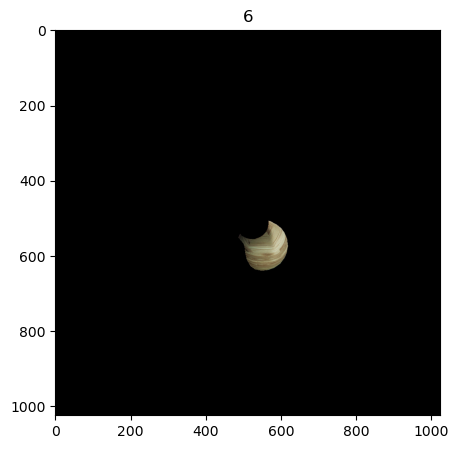

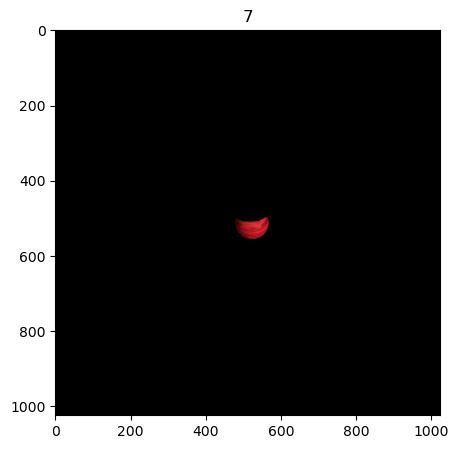

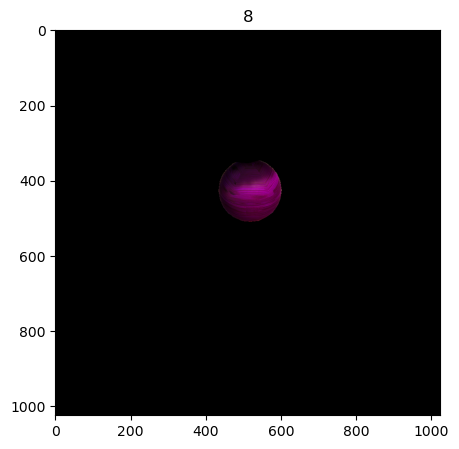

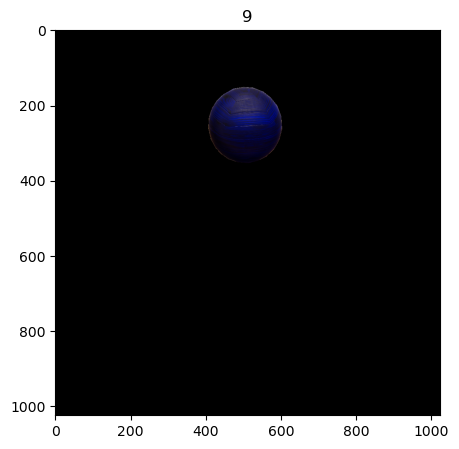

In [11]:
# loop over all seg masks
for o_id, color in zip(object_ids, object_segmentation_colors):
    area = get_mask_area(seg_arr[0], [color])
    image_masked = blackout_image(rgbds[0][...,:3], area)
    rgb_masked = image_masked[..., 0:3]

    fig = plt.figure(figsize=[5, 5])
    ax = fig.add_subplot(111)
    ax.imshow(rgb_masked)
    ax.set_title(f"{o_id}")

In [27]:
rgbds[1][...,:3]-rgbds[0][...,:3]

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00392157,  0.        ,  0.        ],
        ...,
        [-0.00392157, -0.00392157, -0.00392157],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00392157, -0.00392157,  0.        ]],

       [[ 0.00392157,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.00392157,  0.00392157,  0.        ],
        ...,
        [ 0.00392157,  0.00392157,  0.00392157],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00392157, -0.00392157, -0.00392157]],

       [[ 0.00392157,  0.00392157,  0.        ],
        [ 0.        , -0.00392157, -0.00392157],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [-0.00392157,  0.        ,  0.        ],
        [-0.00392157,  0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        , -0.00392157],
        [ 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16078431372549018..0.18039215686274512].


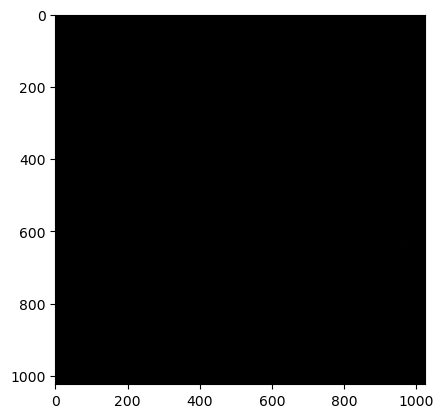

In [22]:
plt.imshow(rgbds[1][...,:3]-rgbds[0][...,:3])

In [12]:
(rgbds[t2] - rgbds[t1]).shape

(1024, 1024, 4)

In [13]:
rgbds[t2] - rgbds[t1]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.00392157,  0.        ,  0.00392157,  0.        ],
        [ 0.00392157,  0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00392157, -0.00392157,  0.        ,  0.        ],
        [ 0.00392157,  0.00392157,  0.        ,  0.        ]],

       [[ 0.        ,  0.        , -0.00392157,  0.        ],
        [ 0.00392157,  0.00392157,  0.00392157,  0.        ],
        [-0.00392157, -0.00392157,  0.        ,  0.        ],
        ...,
        [ 0.00392157,  0.00392157,  0.00392157,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00392157, -0.00392157, -0.00392157,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00392157,  0.        , -0.00392157,  0.        ],
        [-0.00392157,  0.        ,  0.        ,  0.        ],
        ...,
        [-0.00392157,  0.  

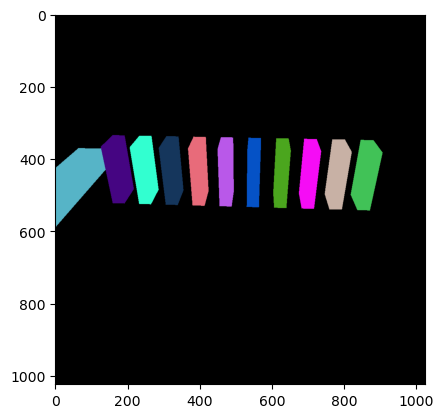

In [14]:
plt.imshow(seg_arr[0])

In [2]:
import os
import h5py
import numpy as np

In [4]:
path = '/home/haoliangwang/data/physion_hdf5/'
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.hdf5'):
            with h5py.File(os.path.join(root, file), "r") as f:
                fwait = np.array(f["static"]["push_time"])
                # push_force = np.array(f["static"]["push_force"])
            print(fwait, file)

1 pilot-containment-cone-plate_0031.hdf5
1 pilot-containment-bowl-familiarization_0018.hdf5
1 pilot-containment-bowl_0026.hdf5
1 pilot-containment-multi-bowl_0048.hdf5
1 pilot-containment-cylinder-bowl_0021.hdf5
5 pilot-containment-vase_torus_0033.hdf5
1 pilot-containment-multi-bowl_0029.hdf5
1 pilot-containment-bowl-familiarization_0033.hdf5
5 pilot-containment-vase_torus_0009.hdf5
1 pilot-containment-multi-bowl_0025.hdf5
5 pilot-containment-vase_torus_0043.hdf5
5 pilot-containment-vase_torus_0031.hdf5
1 pilot-containment-bowl-familiarization_0026.hdf5
5 pilot-containment-vase_torus_0032.hdf5
1 pilot-containment-torus_0022.hdf5
1 pilot-containment-bowl-familiarization_0024.hdf5
1 pilot-containment-bowl-familiarization_0035.hdf5
1 pilot-containment-bowl_0000.hdf5
1 pilot-containment-cylinder-bowl_0010.hdf5
5 pilot-containment-vase_0000.hdf5
1 pilot-containment-cylinder-bowl_0028.hdf5
1 pilot-containment-cylinder-bowl_0026.hdf5
1 pilot-containment-multi-bowl_0042.hdf5
1 pilot-containmen